### 案例网址如下：
https://shap.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

shap.initjs()

d:\Study\Python\Anaconda\envs\transformer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# read in the data
prefix = "../data/league-of-legends-ranked-matches/"
matches = pd.read_csv(prefix+"matches.csv")
participants = pd.read_csv(prefix+"participants.csv")
# 当 low_memory=False 时，pandas 会一次性将整个文件读取到内存中，并推断每列的类型。
# 这种方式会占用更多内存，但可以提高数据类型推断的准确性
stats1 = pd.read_csv(prefix+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(prefix+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10*60,:]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    # 将列的数据类型转换为 category 类型
    allstats[c] = allstats[c].astype('category')
    # 将分类类型转换为数值编码，每个类别会被编码为一个整数。
    # 例如，某列有三个类别 "A"、"B"、"C"，它们可能会被编码为 0、1 和 2。
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

# 划分数据集
X = allstats.drop(["win"], axis=1)
y = allstats["win"]

# convert all features we want to consider as rates
# 这段代码的主要目的是对原始特征进行标准化，将它们转换为每分钟的速率或者游戏时长的比例，
# 以便使不同特征的尺度一致，从而提高模型训练的效果和稳定性。
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60 # per minute rate

# convert to fraction of game
# longesttimespentliving表示玩家在游戏中连续存活的最长时间（单位为秒）
# 这里将其转换为相对于整个游戏时长的比例，使其值在0到1之间
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
# 字典的键是数据集中原始的列名，值是经过描述性的重命名
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}

# full_names.get(n1, n2) 尝试从字典 full_names 中查找键 n1 对应的值。
# 如果字典中存在键 n1，则返回对应的友好名称；如果不存在，则返回原始名称 n2。
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
# xgb.DMatrix 是 XGBoost 提供的数据格式，用于提高训练速度和内存效率
# label=yt.values 和 label=yv.values：分别为训练集和验证集的目标变量。
# yt.values 和 yv.values 将 Pandas 系列对象转换为 NumPy 数组格式，这样更适合 XGBoost 的输入格式。
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [5]:
# 训练一个XGBoost模型
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}

# [(dt, "train"), (dv, "valid")]：指定训练集和验证集的评估数据。
# 训练过程中，XGBoost 会在每轮迭代后输出这两个数据集上的评估结果。
# verbose_eval=25：每 25 轮输出一次训练信息，显示当前轮数及相应的评估指标值。
model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

d:\Study\Python\Anaconda\envs\transformer\lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
d:\Study\Python\Anaconda\envs\transformer\lib\site-packages\xgboost\core.py:158: UserWarning: [16:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.54147	valid-logloss:0.54146
[25]	train-logloss:0.28916	valid-logloss:0.28950
[50]	train-logloss:0.25479	valid-logloss:0.25632
[75]	train-logloss:0.23665	valid-logloss:0.23895
[100]	train-logloss:0.22484	valid-logloss:0.22781
[125]	train-logloss:0.21495	valid-logloss:0.21866
[150]	train-logloss:0.20707	valid-logloss:0.21150
[175]	train-logloss:0.19964	valid-logloss:0.20463
[200]	train-logloss:0.19296	valid-logloss:0.19856
[225]	train-logloss:0.18677	valid-logloss:0.19287
[250]	train-logloss:0.18128	valid-logloss:0.18795
[275]	train-logloss:0.17572	valid-logloss:0.18268
[299]	train-logloss:0.17082	valid-logloss:0.17823


In [6]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [7]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

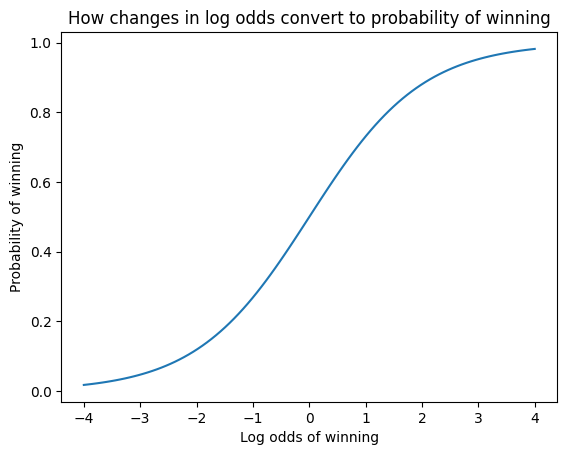

In [8]:
# np.linspace(start, stop, num)：生成 num 个均匀分布的数值，从 start 到 stop。
# 这里生成的是从 -4 到 4 的 100 个均匀分布的数值。
xs = np.linspace(-4,4,100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1/(1+np.exp(-xs)))
pl.show()

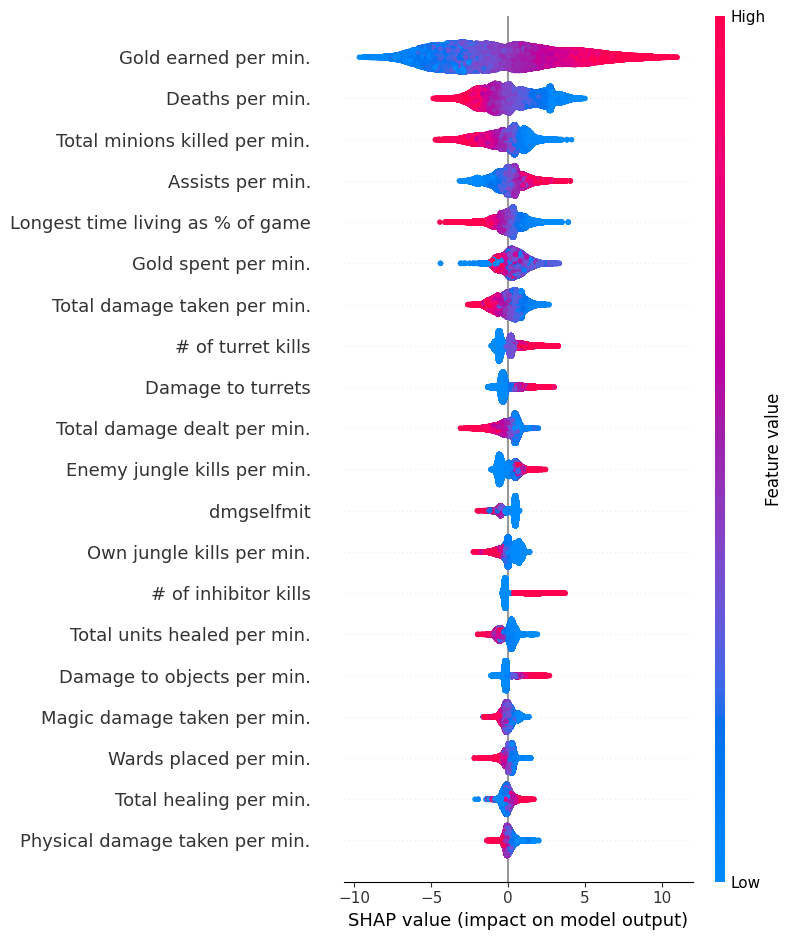

In [11]:
shap.summary_plot(shap_values, Xv)

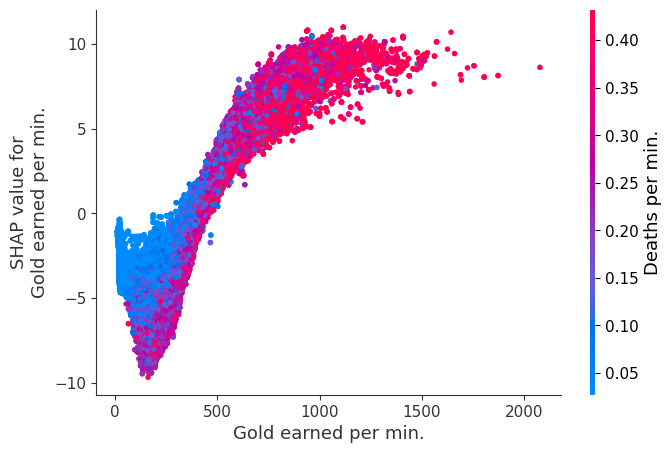

In [12]:
shap.dependence_plot("Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min.")

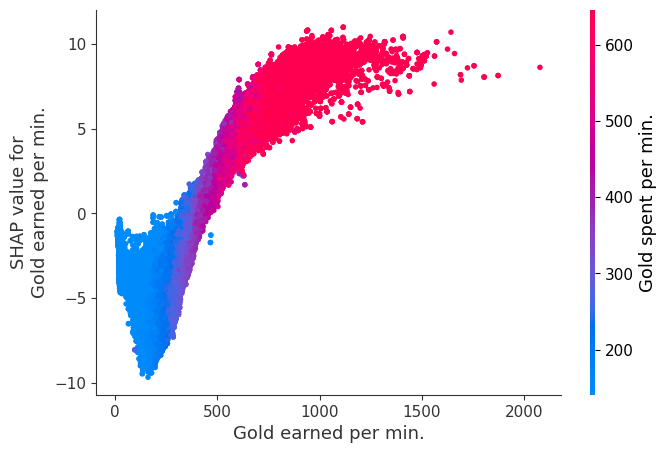

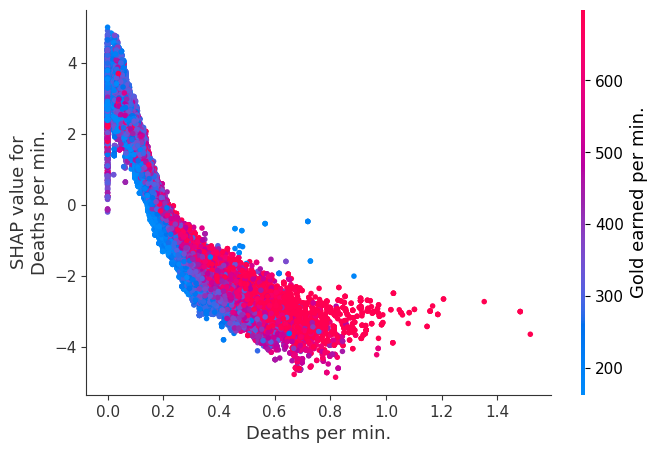

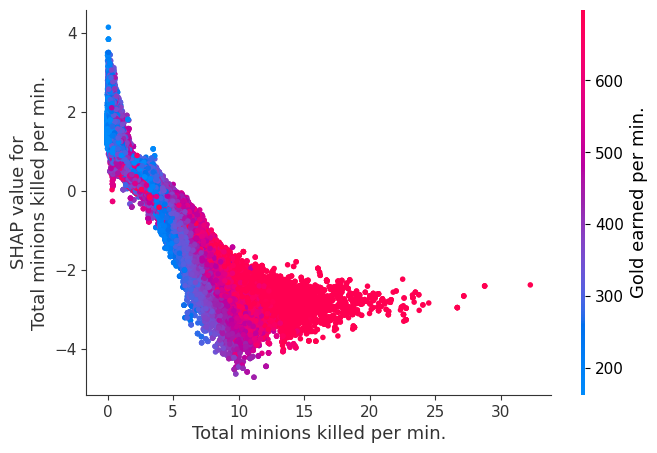

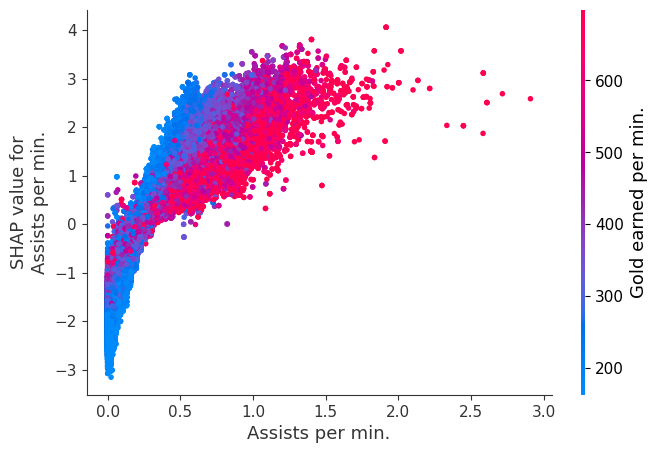

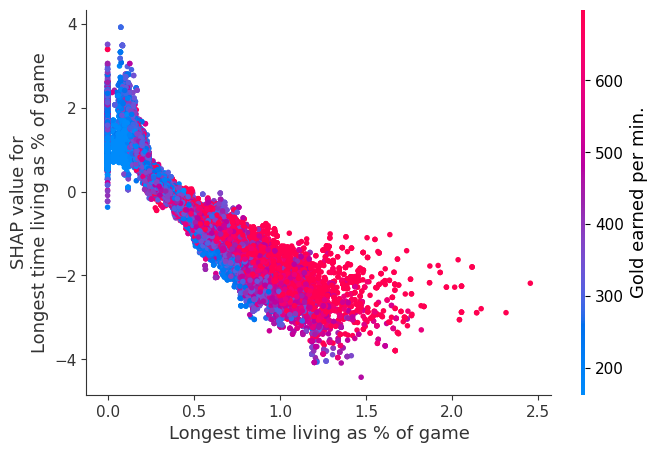

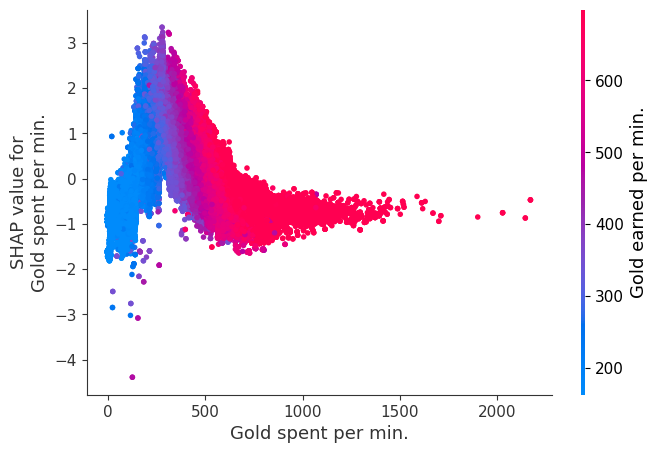

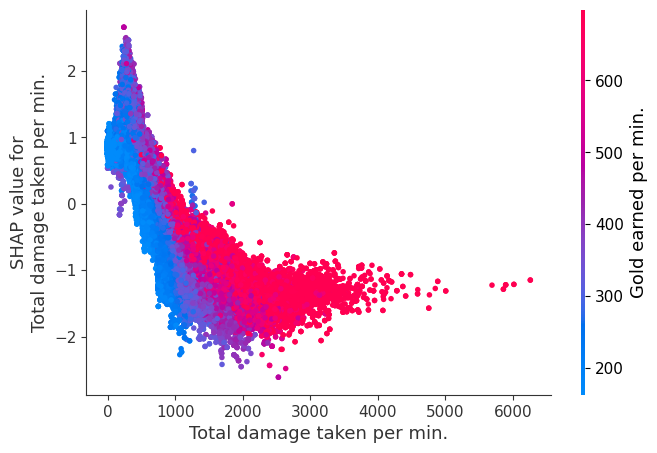

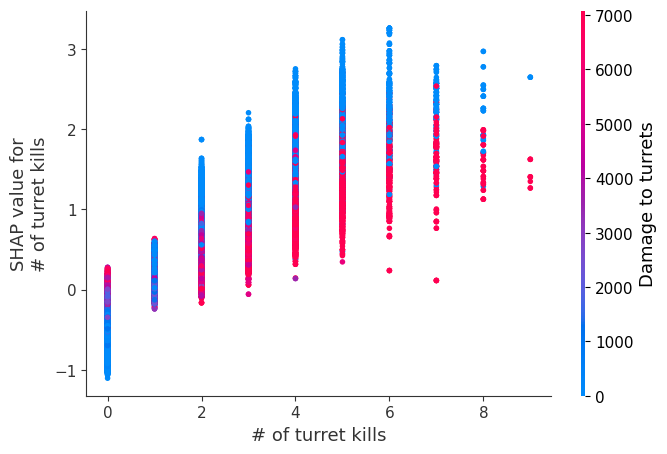

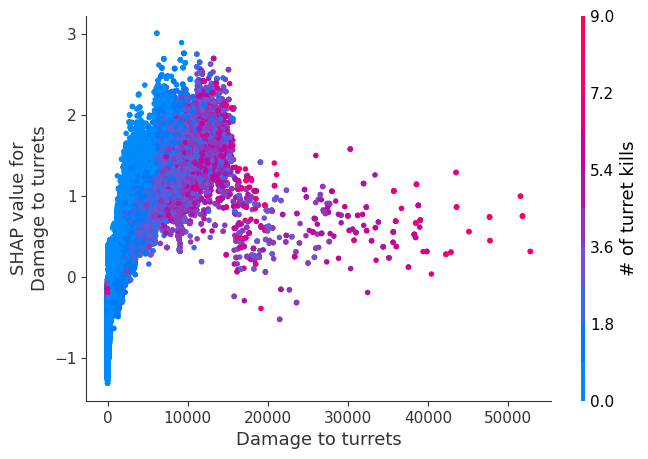

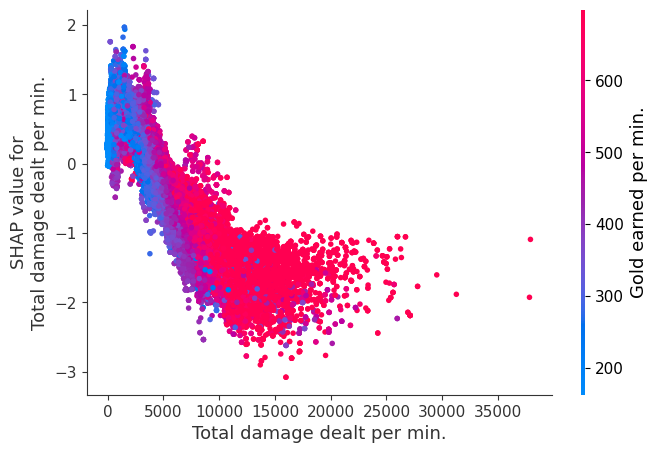

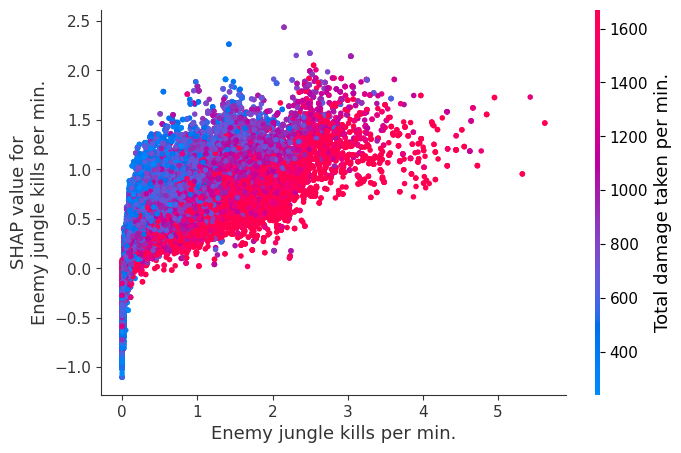

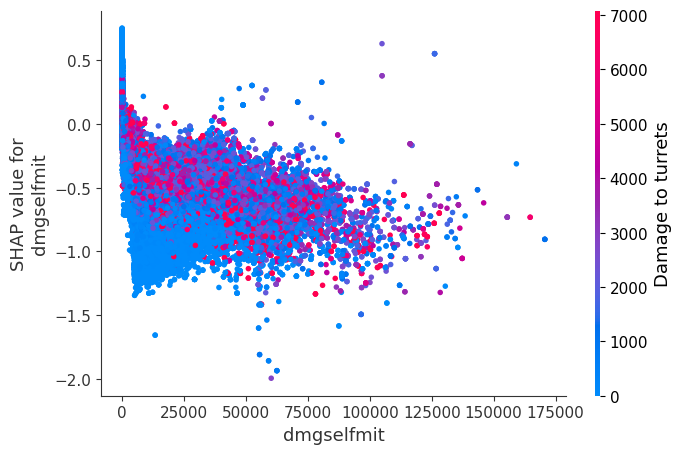

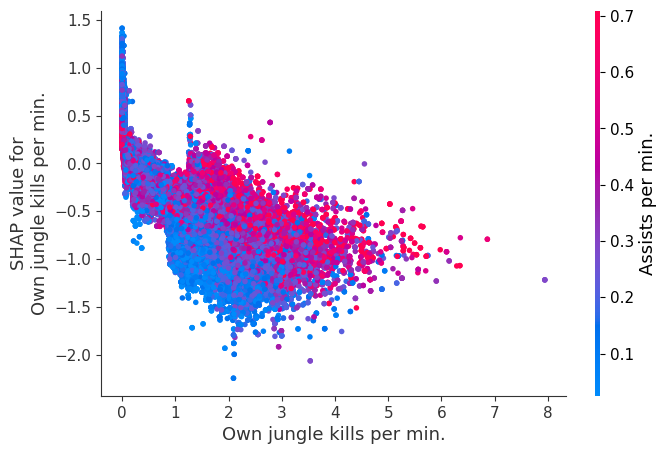

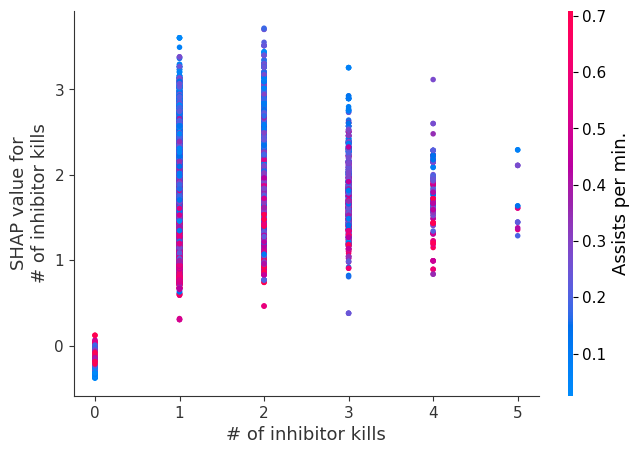

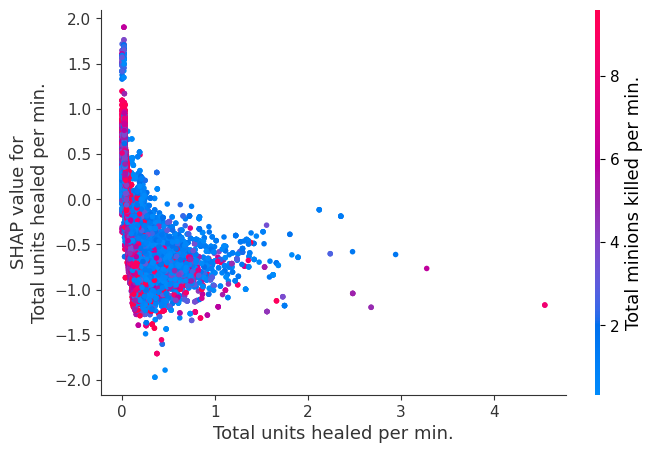

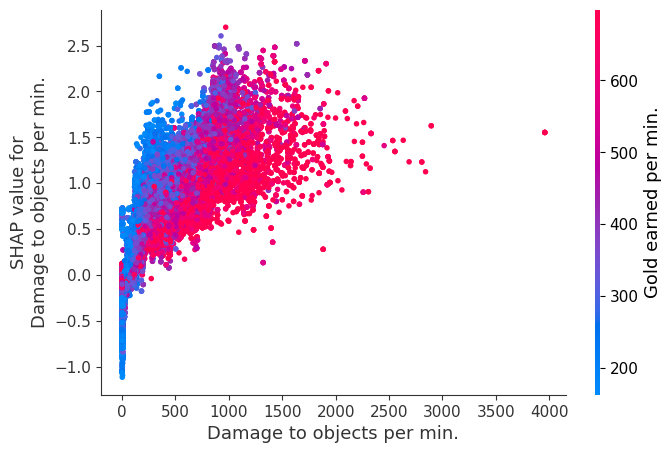

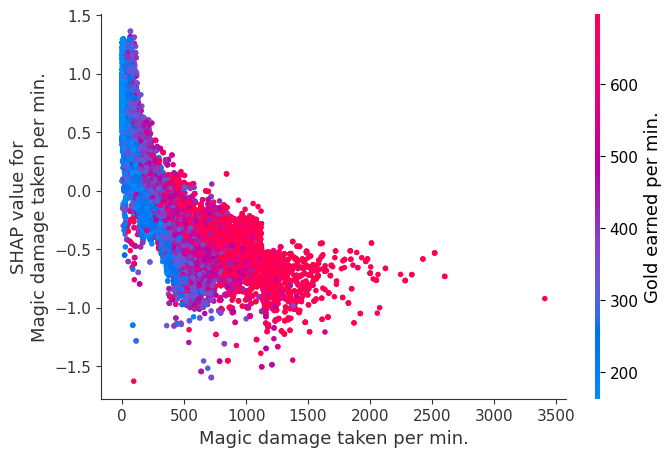

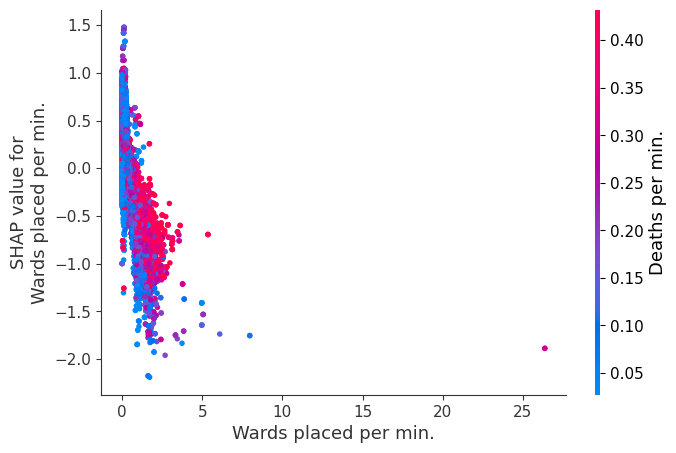

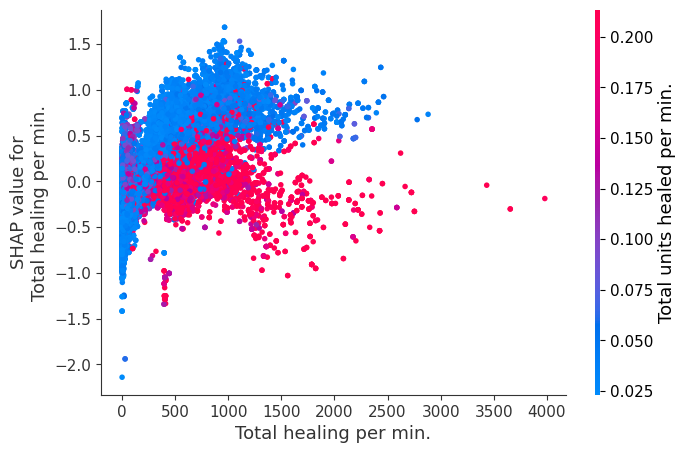

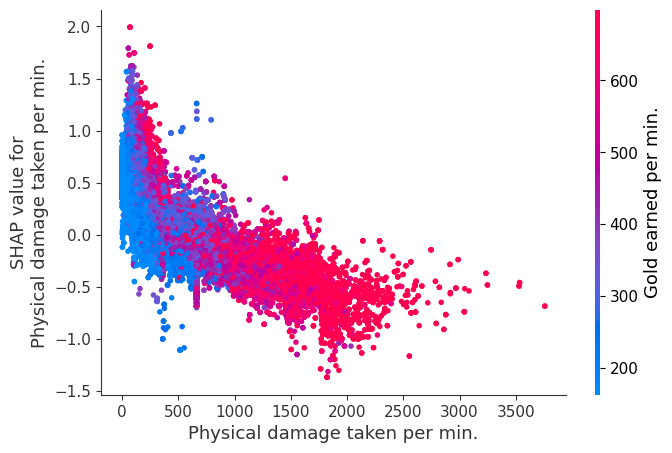

In [13]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)